In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
TRAINING_SIZE = 40000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+ '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '+',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [7]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 40000


In [8]:
print(questions[:5], expected[:5])

['279+847', '2+171  ', '27+5   ', '3+58   ', '288+8  '] ['1126', '173 ', '32  ', '61  ', '296 ']


# Processing

In [9]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [10]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:10000]
train_y = y[:10000]
test_x = x[10000:]
test_y = y[10000:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(9000, 7, 12)
(9000, 4, 12)
Validation Data:
(1000, 7, 12)
(1000, 4, 12)
Testing Data:
(30000, 7, 12)
(30000, 4, 12)


In [11]:
print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

input:  [[[False False False False  True False False False False False False
   False]
  [False False False False  True False False False False False False
   False]
  [False False False  True False False False False False False False
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False False False False  True False False
   False]
  [False False False False False False False  True False False False
   False]
  [False False False  True False False False False False False False
   False]]

 [[False False False False  True False False False False False False
   False]
  [False False False False False False False False False False  True
   False]
  [False  True False False False False False False False False False
   False]
  [False False False False False  True False False False False False
   False]
  [False False False False False False False False  True False False
   False]
  [False False False  True False False Fal

# Build Model

In [12]:
print('Build model...')
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector

############################################
##### Build your own model here ############
############################################
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


# Training

In [13]:
import matplotlib.pyplot as plt
training = model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=200,
              validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 9000 samples, validate on 1000 samples
Epoch 1/200
9000/9000 [==============================] - 3s 350us/step - loss: 2.1175 - acc: 0.2669 - val_loss: 1.8920 - val_acc: 0.3380
Epoch 2/200
9000/9000 [==============================] - 1s 129us/step - loss: 1.8560 - acc: 0.3343 - val_loss: 1.8366 - val_acc: 0.3450
Epoch 3/200
9000/9000 [==============================] - 1s 138us/step - loss: 1.8313 - acc: 0.3424 - val_loss: 1.8221 - val_acc: 0.3500 0s - loss: 1.8356 - a
Epoch 4/200
9000/9000 [==============================] - 1s 130us/step - loss: 1.8018 - acc: 0.3470 - val_loss: 1.7944 - val_acc: 0.3462
Epoch 5/200
9000/9000 [==============================] - 1s 149us/step - loss: 1.7895 - acc: 0.3461 - val_loss: 1.7885 - val_acc: 0.3472
Epoch 6/200
9000/9000 [==============================] - 1s 132us/step - loss: 1.7759 - acc: 0.3477 - val_loss: 1.7714 - val_acc: 0.3502
Epoch 7/200
9000/9000 [==============================] - 1s 

9000/9000 [==============================] - 1s 141us/step - loss: 0.4436 - acc: 0.8619 - val_loss: 0.6732 - val_acc: 0.7378
Epoch 59/200
9000/9000 [==============================] - 1s 141us/step - loss: 0.4267 - acc: 0.8688 - val_loss: 0.6585 - val_acc: 0.7468
Epoch 60/200
9000/9000 [==============================] - 1s 142us/step - loss: 0.4132 - acc: 0.8722 - val_loss: 0.6466 - val_acc: 0.7460
Epoch 61/200
9000/9000 [==============================] - 1s 141us/step - loss: 0.3959 - acc: 0.8810 - val_loss: 0.6372 - val_acc: 0.7465
Epoch 62/200
9000/9000 [==============================] - 1s 141us/step - loss: 0.3816 - acc: 0.8874 - val_loss: 0.6371 - val_acc: 0.7532
Epoch 63/200
9000/9000 [==============================] - 1s 141us/step - loss: 0.3708 - acc: 0.8925 - val_loss: 0.6170 - val_acc: 0.7565
Epoch 64/200
9000/9000 [==============================] - 1s 141us/step - loss: 0.3501 - acc: 0.9023 - val_loss: 0.6170 - val_acc: 0.7615
Epoch 65/200
9000/9000 [=======================

9000/9000 [==============================] - 1s 152us/step - loss: 0.0467 - acc: 0.9966 - val_loss: 0.6277 - val_acc: 0.7915
Epoch 118/200
9000/9000 [==============================] - 1s 141us/step - loss: 0.1494 - acc: 0.9534 - val_loss: 0.7215 - val_acc: 0.7785
Epoch 119/200
9000/9000 [==============================] - 1s 142us/step - loss: 0.1896 - acc: 0.9382 - val_loss: 0.6505 - val_acc: 0.7863
Epoch 120/200
9000/9000 [==============================] - 1s 141us/step - loss: 0.0929 - acc: 0.9786 - val_loss: 0.5730 - val_acc: 0.8090
Epoch 121/200
9000/9000 [==============================] - 1s 141us/step - loss: 0.0438 - acc: 0.9983 - val_loss: 0.5503 - val_acc: 0.8220
Epoch 122/200
9000/9000 [==============================] - 1s 144us/step - loss: 0.0339 - acc: 0.9997 - val_loss: 0.5486 - val_acc: 0.8205
Epoch 123/200
9000/9000 [==============================] - 1s 147us/step - loss: 0.0306 - acc: 0.9998 - val_loss: 0.5547 - val_acc: 0.8200
Epoch 124/200
9000/9000 [================

9000/9000 [==============================] - 1s 141us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.6422 - val_acc: 0.8218
Epoch 177/200
9000/9000 [==============================] - 1s 141us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.6418 - val_acc: 0.8203
Epoch 178/200
9000/9000 [==============================] - 1s 147us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.6472 - val_acc: 0.8218
Epoch 179/200
9000/9000 [==============================] - 1s 150us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.6499 - val_acc: 0.8215
Epoch 180/200
9000/9000 [==============================] - 1s 140us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.6502 - val_acc: 0.8230
Epoch 181/200
9000/9000 [==============================] - 1s 141us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.6568 - val_acc: 0.8220
Epoch 182/200
9000/9000 [==============================] - 1s 142us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.6590 - val_acc: 0.8210
Epoch 183/200
9000/9000 [================

Text(0.5,1,'3 digits add')

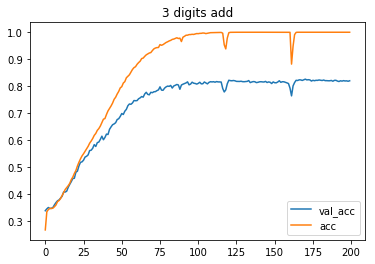

In [14]:
val_acc = training.history['val_acc']
acc = training.history['acc']
plt.figure()
plt.plot(val_acc, label = 'val_acc')
plt.plot(acc, label = 'acc')
plt.legend(loc='lower right')
plt.title('3 digits add')

# Testing

In [15]:
print("MSG : Prediction")
#####################################################
## Try to test and evaluate your model ##############
## ex. test_x = ["555+175", "860+7  ", "340+29 "]
## ex. test_y = ["730 ", "867 ", "369 "] 
#####################################################
#####################################################
correct_ct = 0
accuracy = 0
for i in range(len(test_x)):
    ind = np.random.randint(0, len(test_x))
    rowx, rowy = test_x[np.array([ind])], test_y[np.array([ind])]
    preds = model.predict_classes(rowx, verbose=0)
    q = ctable.decode(rowx[0])
    correct = ctable.decode(rowy[0])
    guess = ctable.decode(preds[0], calc_argmax=False)
    if correct == guess:
        correct_ct = correct_ct + 1
    else: 
        if i < 1000:
            print(i, ' Q', q[::-1] if REVERSE else q, end=' ')
            print('T', correct, end=' ')
            print(colors.fail + '☒' + colors.close, end=' ')
            print(guess)
accuracy = correct_ct/len(test_x)
print('accu:', accuracy)

MSG : Prediction
1  Q 459+21  T 480  ☒ 490 
2  Q 974+655 T 1629 ☒ 1639
6  Q 157+47  T 204  ☒ 184 
8  Q 67+502  T 569  ☒ 559 
13  Q 426+741 T 1167 ☒ 1186
14  Q 376+408 T 784  ☒ 775 
15  Q 64+72   T 136  ☒ 135 
21  Q 773+778 T 1551 ☒ 1552
27  Q 79+110  T 189  ☒ 199 
30  Q 764+94  T 858  ☒ 848 
32  Q 422+137 T 559  ☒ 579 
33  Q 259+191 T 450  ☒ 439 
34  Q 956+702 T 1658 ☒ 1659
40  Q 891+206 T 1097 ☒ 1095
43  Q 80+883  T 963  ☒ 964 
44  Q 562+9   T 571  ☒ 572 
45  Q 771+722 T 1493 ☒ 1572
47  Q 13+443  T 456  ☒ 446 
48  Q 35+962  T 997  ☒ 987 
49  Q 93+161  T 254  ☒ 234 
50  Q 752+593 T 1345 ☒ 1315
51  Q 486+611 T 1097 ☒ 1197
55  Q 203+319 T 522  ☒ 433 
56  Q 973+97  T 1070 ☒ 1021
57  Q 90+456  T 546  ☒ 556 
59  Q 597+695 T 1292 ☒ 1272
60  Q 26+417  T 443  ☒ 352 
62  Q 436+110 T 546  ☒ 456 
64  Q 322+814 T 1136 ☒ 1146
66  Q 2+655   T 657  ☒ 656 
67  Q 885+38  T 923  ☒ 922 
68  Q 46+260  T 306  ☒ 307 
71  Q 558+35  T 593  ☒ 503 
72  Q 6+525   T 531  ☒ 521 
73  Q 80+926  T 1006 ☒ 906 
74  Q 1

428  Q 61+34   T 95   ☒ 94  
429  Q 32+942  T 974  ☒ 964 
432  Q 354+28  T 382  ☒ 372 
433  Q 324+97  T 421  ☒ 411 
434  Q 65+817  T 882  ☒ 872 
436  Q 49+639  T 688  ☒ 697 
438  Q 78+950  T 1028 ☒ 1008
440  Q 494+865 T 1359 ☒ 1379
441  Q 16+402  T 418  ☒ 427 
444  Q 936+695 T 1631 ☒ 1591
445  Q 60+191  T 251  ☒ 231 
446  Q 24+377  T 401  ☒ 301 
449  Q 80+41   T 121  ☒ 120 
453  Q 395+447 T 842  ☒ 832 
454  Q 22+547  T 569  ☒ 579 
456  Q 743+63  T 806  ☒ 706 
457  Q 891+35  T 926  ☒ 906 
458  Q 38+436  T 474  ☒ 464 
459  Q 321+21  T 342  ☒ 351 
461  Q 675+243 T 918  ☒ 908 
462  Q 96+274  T 370  ☒ 360 
463  Q 428+182 T 610  ☒ 500 
466  Q 41+24   T 65   ☒ 66  
470  Q 675+84  T 759  ☒ 768 
475  Q 569+77  T 646  ☒ 636 
476  Q 142+554 T 696  ☒ 606 
477  Q 135+251 T 386  ☒ 376 
478  Q 458+199 T 657  ☒ 647 
479  Q 346+216 T 562  ☒ 452 
482  Q 55+371  T 426  ☒ 427 
484  Q 309+960 T 1269 ☒ 1268
485  Q 679+808 T 1487 ☒ 1587
486  Q 296+115 T 411  ☒ 412 
487  Q 5+211   T 216  ☒ 217 
488  Q 85+326 

852  Q 938+15  T 953  ☒ 952 
853  Q 215+450 T 665  ☒ 776 
855  Q 3+997   T 1000 ☒ 990 
856  Q 98+537  T 635  ☒ 625 
857  Q 389+40  T 429  ☒ 439 
858  Q 511+281 T 792  ☒ 692 
860  Q 302+552 T 854  ☒ 874 
862  Q 281+26  T 307  ☒ 308 
863  Q 731+60  T 791  ☒ 781 
865  Q 483+138 T 621  ☒ 622 
866  Q 502+47  T 549  ☒ 559 
867  Q 239+43  T 282  ☒ 283 
870  Q 764+73  T 837  ☒ 847 
871  Q 201+17  T 218  ☒ 227 
872  Q 402+376 T 778  ☒ 799 
876  Q 8+626   T 634  ☒ 644 
880  Q 903+592 T 1495 ☒ 1484
881  Q 598+53  T 651  ☒ 642 
882  Q 480+18  T 498  ☒ 499 
886  Q 398+305 T 703  ☒ 743 
887  Q 47+214  T 261  ☒ 251 
888  Q 606+435 T 1041 ☒ 1151
889  Q 467+2   T 469  ☒ 479 
890  Q 261+625 T 886  ☒ 987 
891  Q 925+16  T 941  ☒ 931 
892  Q 322+8   T 330  ☒ 329 
893  Q 72+920  T 992  ☒ 993 
894  Q 68+580  T 648  ☒ 638 
896  Q 650+632 T 1282 ☒ 1292
897  Q 15+456  T 471  ☒ 481 
898  Q 29+562  T 591  ☒ 581 
902  Q 371+74  T 445  ☒ 444 
903  Q 846+69  T 915  ☒ 934 
904  Q 941+85  T 1026 ☒ 1037
906  Q 436+938

accu: 0.47